In [2]:
# ! conda create -n Homework python=3.8
# ! conda activate Homework
# ! pip install -r requirements.txt
# ! pip install plotly==4.14.3
# ! pip install scanpy==1.7.2
# ! pip install seaborn==0.11.1

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/Homework

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      anaconda/pkgs/main/linux-64::_libgcc_mutex-0.1-main None
  _openmp_mutex      anaconda/pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu None
  ca-certificates    anaconda/pkgs/main/linux-64::ca-certificates-2023.01.10-h06a4308_0 None
  certifi            anaconda/pkgs/main/linux-64::certifi-2022.12.7-py38h06a4308_0 None
  ld_impl_linux-64   anaconda/pkgs/main/linux-64::ld_impl_linux-64-2.38-h1181459_1 None
  libffi             anaconda/pkgs/main/linux-64::libffi-3.4.2-h6a678d5_6 None
  libgcc-ng          anaconda/pkgs/main/linux-64::libgcc-ng-11.2.0-h1234567_1 None
  libgomp            anaconda/pkgs/main/linux-64::libgomp-11.2.0-h1234567_1 None
  libstdcxx-ng       anaconda/pkgs/main/linux-64::libstdcxx-ng-11.2.0-h1234567_1 None
  ncurses            anaconda/pkgs/main/linux-64::ncu

In [1]:
from dv_train import dvnet_train
from scipy.io import mmread

import pandas as pd
import numpy as np
import plotly.io as plt_io
import plotly.graph_objects as go
import scanpy as sc
import manifolds.poincare as poincare
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch

/opt/anaconda3/envs/Homework/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_mtx(filename, dtype='int32'):
    x = mmread(filename).astype(dtype)
    return x

In [3]:
def Loaddataset(name='cd14'):

    # Load singcell RNA-seq data
    if name == 'cd14': # 
        mtx = './data/cd14_monocyte_erythrocyte.mtx'
        data = read_mtx(mtx)
        data = np.asarray(data.transpose().todense())
        label = pd.read_csv('data/cd14_monocyte_erythrocyte_celltype.tsv', sep='\t', header=None).values
        label_batch = None
        batch_class = [1]

    if name == 'lung':
        mtx = './data/lung_human_ASK440.mtx' # https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE130148
        data = read_mtx(mtx)
        data = np.asarray(data.transpose().todense())
        label = pd.read_csv('data/lung_human_ASK440_celltype.tsv', sep='\t', header=None).values
        label_batch = None
        batch_class = [1]

    if name == 'celegan': 
        mtx = './data/celegan.mtx' # https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954
        data = read_mtx(mtx)
        data = np.asarray(data.transpose().todense())
        label = pd.read_csv('data/celegan_embryo_time.tsv', sep='\t', header=None).values
        # label = pd.read_csv('data/celegan_celltype.tsv', sep='\t', header=None).values
        label_batch_ = pd.read_csv('data/celegan_batch.tsv', header=None)
        label_batch = np.asarray(pd.concat([label_batch_, label_batch_], axis=1))
        batch_class = [7, 7]

    if name == 'uc_stromal':
        mtx = './data/uc_stromal.mtx' # https://singlecell.broadinstitute.org/single_cell/study/SCP259
        data = read_mtx(mtx)
        data = np.asarray(data.transpose().todense())
        label = pd.read_csv('data/uc_stromal_celltype.tsv', sep='\t', header=None).values
        label_batch_p = pd.read_csv('data/uc_stromal_batch_patient.tsv', header=None)
        label_batch_h = pd.read_csv('data/uc_stromal_batch_health.tsv', header=None)
        label_batch = np.asarray(pd.concat([label_batch_p, label_batch_h], axis=1))
        batch_class = [30, 3]

    if name == 'uc_epi': # https://singlecell.broadinstitute.org/single_cell/study/SCP259
        mtx = './data/uc_epi.mtx'
        data = read_mtx(mtx)
        data = np.asarray(data.transpose().todense())
        label = pd.read_csv('data/uc_epi_celltype.tsv', sep='\t', header=None).values
        label_batch_p = pd.read_csv('data/uc_epi_batch_patient.tsv', header=None)
        label_batch_h = pd.read_csv('data/uc_epi_batch_health.tsv', header=None)
        label_batch_l = pd.read_csv('data/uc_epi_batch_location.tsv', header=None)
        label_batch = np.asarray(pd.concat([label_batch_p, label_batch_h, label_batch_l], axis=1))
        batch_class = [30, 3, 2]

    return data, label, label_batch, batch_class

In [5]:
data, label, label_batch, batch_class = Loaddataset(name='lung')

In [6]:
####### "manifold" hyperparameter: "Euclidean" means to choose the Euclidean embedding space, "PoincareBall" or "Hyperboloid" means to choose the hyperbolic space 
mod_config = {
    "data_name": "SingleCell",
    "nu": 1e-3, # hyperparameter for similarity >> range (5e-3 ~ 1e-2)
    "num_latent_dim": 2, # latent space dimension >> range (5e-3 ~ 1e-2)
    "gamma": 10, # hyperparamer for augmentation >> range (10, 100, 1000, 10000)
    "beta": 100, # hyperparameter for batch correction >> range (1e-2 ~ 100)
    "manifold": "Hyperboloid", # manfiold space >> Euclidean, PoincareBall, Hyperboloid
    "batch_class": batch_class, # number of batch
    "raw_data": data,
    "raw_label": label,
    "raw_label_batch": label_batch,
    "gpu": 0, # whether to use gpu: 1
    }

In [7]:
embedding = dvnet_train(mod_config) # main function: dimensionality reduction and visualization method for single cell with/without batch effect

Global seed set to 1


Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=300, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
  )
)
Classifier(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): L

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/opt/anaconda3/envs/Homework/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


use kNN method to find the sigma



  | Name           | Type        | Params
-----------------------------------------------
0 | rie_pro_input  | ToEuclidean | 0     
1 | rie_pro_latent | ToLorentz   | 0     
2 | generator      | Generator   | 207 K 
3 | classifier     | Classifier  | 61.5 K
4 | Loss           | MyLoss      | 0     
5 | criterion      | MSELoss     | 0     
-----------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.077     Total estimated model params size (MB)
/opt/anaconda3/envs/Homework/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/anaconda3/envs/Homework/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 199: 100%|██████████| 14/14 [00:02<00:00,  6.19it/s, loss=0.00592, v_num=0]


In [8]:
# for hyperbolic method
class PoincareMaps:
    def __init__(self, coordinates, model_name='dv', cpalette=None):
        self.coordinates = coordinates
        self.distances = None       
        self.radius = np.sqrt(coordinates[:,0]**2 + coordinates[:,1]**2)
        self.iroot = np.argmin(self.radius)
        self.labels_pos = None
        self.model_name = model_name
        colors_palette = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD',
                  '#8C564B', '#E377C2', '#BCBD22', '#17BECF', '#40004B',
                  '#762A83', '#9970AB', '#C2A5CF', '#E7D4E8', '#F7F7F7',
                  '#D9F0D3', '#A6DBA0', '#5AAE61', '#1B7837', '#00441B',
                  '#8DD3C7', '#FFFFB3', '#BEBADA', '#FB8072', '#80B1D3',
                  '#FDB462', '#B3DE69', '#FCCDE5', '#D9D9D9', '#BC80BD',
                  '#CCEBC5', '#FFED6F', '#edf8b1', '#c7e9b4', '#7fcdbb',
                  '#41b6c4', '#1d91c0', '#225ea8', '#253494', '#081d58']
        if cpalette is None:
            self.colors_palette = colors_palette
        else:
            self.colors_palette = cpalette

    def poincare_distance(self, x):
        PoincareBall = poincare.PoincareBall()
        dist = PoincareBall.sqdist_xu_mobius_v2(x, x, c=1)
        dist = dist.clamp(min=1e-22)
        return dist

    def get_geodesic_parameters(self, u, v, eps=1e-10):
        if all(u) == 0:
            u = np.array([eps, eps])
        if all(v) == 0:
            v = np.array([eps, eps])

        nu = u[0]**2 + u[1]**2
        nv = v[0]**2 + v[1]**2
        a = (u[1]*nv - v[1]*nu + u[1] - v[1]) / (u[0]*v[1] - u[1]*v[0])
        b = (v[0]*nu - u[0]*nv + v[0] - u[0]) / (u[0]*v[1] - u[1]*v[0])
        return a, b

    def plot_poincare_disc(self, x, manifold=None, radius=None, labels=None, model_name=None,
        labels_name='labels', labels_order=None, labels_pos=None, labels_text=None,
                        coldict=None,
                        d1=4.5, d2=4.0, fs=9, ms=20,
                        u=None, v=None, alpha=1.0,
                        col_palette=plt.get_cmap("tab10"), print_labels=True,
                        bbox=(1.3, 0.7), leg=True, ft='png'):

        idx = np.random.permutation(len(x))
        df = pd.DataFrame(x[idx, :], columns=['pm1', 'pm2'])
        
        fig = plt.figure(figsize=(d1, d2))
        ax = plt.gca()

        if manifold != 'Euclidean':
            circle = plt.Circle((0, 0), radius=radius,  fc='none', color='black')
            ax.add_patch(circle)
        ax.plot(0, 0, '.', c=(0, 0, 0), ms=4)

        if not (labels is None):
            df[labels_name] = labels[idx]
            if labels_order is None:
                labels_order = np.unique(labels)
            if coldict is None:
                coldict = dict(zip(labels_order, col_palette[:len(labels)]))
            sns.scatterplot(x="pm1", y="pm2", hue=labels_name, sizes=1,
                            hue_order=labels_order,
                            palette=coldict,
                            alpha=alpha, edgecolor="none",
                            data=df, ax=ax, s=ms)
            
            if leg:
                ax.legend(fontsize=fs, loc='best', bbox_to_anchor=bbox, facecolor='white')
            else:
                ax.legend_.remove()

        else:
            sns.scatterplot(x="pm1", y="pm2",
                            data=df, ax=ax, s=ms)

            if leg == False:
                ax.legend_.remove()

        if not (u is None):
            a, b = self.get_geodesic_parameters(u, v)
            circle_geo = plt.Circle((-a/2, -b/2), radius=np.sqrt(a**2/4 + b**2/4 - 1),  fc='none', color='grey')
            ax.add_patch(circle_geo)

        fig.tight_layout()
        ax.axis('off')
        ax.axis('equal')
 
        if print_labels:
            if labels_text is None:
                labels_list = np.unique(labels)
            else:
                labels_list = np.unique(labels_text)
            if labels_pos is None:
                labels_pos = {}
                for l in labels_list:
                    ix_l = np.where(labels == l)[0]
                    Dl = self.poincare_distance_dhv(torch.DoubleTensor(x[ix_l, :])).numpy()
                    i = ix_l[np.argmin(Dl.sum(axis=0))]
                    labels_pos[l] = i

            for l in labels_list:
                ax.text(x[labels_pos[l], 0], x[labels_pos[l], 1], l, fontsize=fs)
                
        if manifold != 'Euclidean':
            ax.set_ylim([-1.01, 1.01])
            ax.set_xlim([-1.01, 1.01])

        plt.tight_layout()
        plt.show()

        # if ft == 'png':
        #     plt.savefig('dv_result.' + ft, format=ft, dpi=600)

        return labels_pos

    def plot(self, pm_type='ori', labels=None, manifold=None,
        labels_name='labels', print_labels=False, labels_text=None,
        labels_order=None, coldict=None, alpha=1.0,
        d1=4.5, d2=4.0, fs=9, ms=20, bbox=(1.3, 0.7), u=None, v=None, leg=True, ft='png'):                        
        if pm_type == 'ori':
            coordinates = self.coordinates
            radius_new = np.sqrt(coordinates[:,0]**2 + coordinates[:,1]**2).max()
        
        elif pm_type == 'rot':
            coordinates = self.coordinates_rotated
            radius_new = np.sqrt(coordinates[:,0]**2 + coordinates[:,1]**2).max()

        if labels_order is None:
            labels_order = np.unique(labels)

        self.labels_pos = self.plot_poincare_disc(coordinates, manifold=manifold, radius=radius_new, model_name=self.model_name,
            print_labels=print_labels, labels_text=labels_text,
            labels=labels, labels_name=labels_name, labels_order=labels_order, labels_pos = self.labels_pos,
                       coldict=coldict, u=u, v=v, alpha=alpha,
                       d1=d1, d2=d2, fs=fs, ms=ms, col_palette=self.colors_palette, bbox=bbox, leg=leg, ft=ft)

In [9]:
if mod_config["manifold"] == "Hyperboloid":
    embedding = embedding[:, 1:3] / np.expand_dims(1 + embedding[:, 0], axis=1) # Lorentz space to Poincaré disk

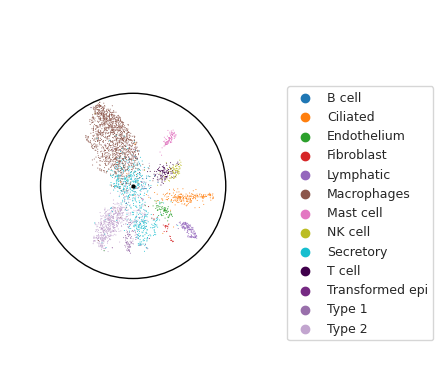

In [10]:
model = PoincareMaps(embedding, model_name='dv')
model.plot('ori', labels=label, manifold=mod_config["manifold"], bbox=(1.1, 0.8), ms=0.5, coldict=None) # plot embedding on Poincaré disk